In [2]:
pip install biocircuits


In [3]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

import biocircuits

# Plotting modules
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting


Queremos realizar una simulacion estocastica de la produccion de biodiesel
en E. coli. Se tienen las ecuaciones que nos rigen la produccion de los alcanos:

\begin{equation}
    \begin{aligned}
    \frac{d[F]}{dt} & = -k_{1}[E_1][F] + k_{-1}[FE_1] + a_+ [F']- a_- [F],\\
    \frac{d[FE_1]}{dt} & = k_{1}[E_1][F] -(k_2 + k_{-1})[FE_1],\\
    \frac{d[E_1]}{dt} & = -k_{1}[E_1][F] + (k_2 + k_{-1})[FE_1],\\
    \frac{d[Adh]}{dt} & = k_2 [FE_1] - k_{3}[E_2][Adh] + k_{-3}[AdhE_2].\\
    \frac{d[AdhE_2]}{dt} & = k_{3}[E_2][Adh] -(k_4 + k_{-3})[AdhE_2],\\
    \frac{d[E_2]}{dt} & = -k_{3}[E_2][Adh] + (k_4 + k_{-3})[AdhE_2],\\
    \frac{d[Ak]}{dt} & = k_4 [AdhE_2].\\
    \end{aligned}
\end{equation}

Me basare en la simulacion realizada Michael Elowitz.

Tenemos entonces diversas propensidades, termino que denota la probabilidad de transicion de un estado a otro. Tenemos entonces:



| Reaction      | Propensity |
| ---------- | ---------- |
| $$F'-> F'+1, F -> F - 1$$| $$a_-*F$$|
| $$F'-> F'-1, F -> F+1$$| $$a_+*F'$$|
| $$F-> F-1,E_1 -> E_1-1, FE_1 -> FE_1+1$$| $$k_1(E_1)(F)$$|
| $$F-> F+1, E_1 -> E_1 +1, FE_1 -> FE_1 -1 $$| $$k_{-1}(FE_1)$$|
| $$FE_1 -> FE_1 - 1,E_1->E_1 +1, Adh -> Adh +1$$| $$k_2(FE_1)$$ |
| $$Adh -> Adh -> -1, E_2 ->E_2 -1, AdhE_2 +1$$| $$k_3(Adh)(E_2)$$|
| $$Adh -> Adh -> +1, E_2 ->E_2 +1, AdhE_2 -1$$|$$k_{-3}(AdhE_2)$$|
| $$AdhE_2 -> AdhE_2 -1, E_2 ->E_2 +1, Ak -> Ak+1$$| $$k_4(AdhE_2)$$|

Para empezar a codificar la simulacion, hacemos un arreglo que nos da los cambios para nuestras reaciones.


In [4]:
def muestraDiscreta(prob):
    #Al azar da un index con probabilidad prob
    #Numero al azar
    n = np.random.rand()
    #Dar indice
    i = 0
    pSum = 0.0
    while pSum < n:
        pSum = pSum + prob[i]
        i = i+1
    return i-1

prob1 = np.array([0.1,0.3,0.4,0.05,0.15,1])


In [5]:
def gillespieChoice(propensitiesFunction,propensities,population,time,args = ()):
    """Nos da la reaccion seleccionada al azar y el tiempo que se demoro en
    hacer la reaccion.
    """
    #Calcular propensities. 
    propensitiesFunction(propensities,population,time,*args)
    
    #Suma de las propensities.
    propsSum = propensities.sum()

    
    
    #Dar nuevo tiempo exponencial.
    t = np.random.exponential(1.0/propsSum)
    
    #Probabilidad discreta de cada reaccion:
    rDProb = propensities/propsSum
    
    #Sacar una reaccion de la distribucion
    reaction = muestraDiscreta(rDProb)
    
    return reaction, t


In [6]:
"""
Tenemos la funcion que escoge nuestra reaccion. Ahora escribimos nuestro 
algoritmo de simulacion estocastico  (ASE)
"""

def gillespieSim1(propensityFunction, 
                  update,population0, 
                  timePoints, 
                  args =()):
    
    #Inicializar el output.
    outSol = np.empty((len(timePoints),update.shape[1]), dtype = int)
    
    #Inicializar y realizar la simulacion.
    timei = 1
    i = 0
    t = timePoints[0]
    population = population0.copy()
    outSol[0,:] = population
    propensities = np.zeros(update.shape[0])
    
    while i < len(timePoints):
        while t < timePoints[timei]:
            #Sacar evento y tiempo que paso para el evento.
            evento, dt = gillespieChoice(propensityFunction, propensities, population, t, args)
            
            #Actualizar la poblacion y el tiempo
            poblacionAnterior = population.copy()
            population += update[evento,:]
            
            t = t + dt
        #Actualizar indice
        i = np.searchsorted(timePoints >t,True)
        outSol[timei: min(i,len(timePoints))] = poblacionAnterior
        timei = i
    return outSol
            
    

In [7]:
simple_update = np.array(
    [
        [1, 0],  # Make mRNA transcript
        [-1, 0],  # Degrade mRNA
        [0, 1],  # Make protein
        [0, -1],  # Degrade protein
    ],
    dtype=int,
)

def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

In [8]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 500

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespieSim1(
        simple_propensity, simple_update, population_0, time_points, args=args
    )  

100%|██████████| 500/500 [02:50<00:00,  2.93it/s]


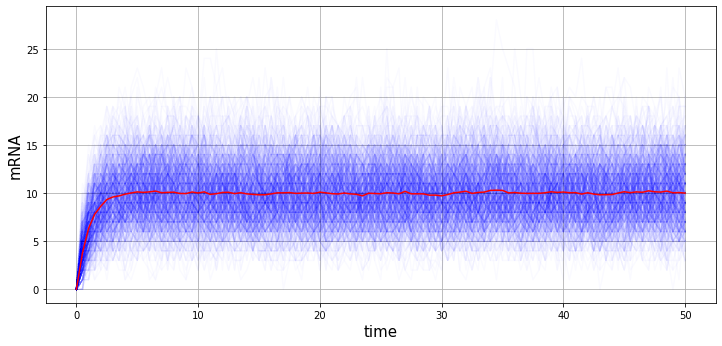

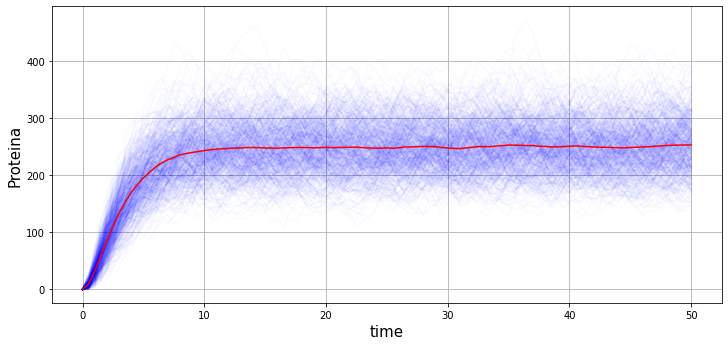

In [13]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time",fontsize=15)
plt.ylabel("mRNA",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,0],alpha=0.02, color ="blue")
plt.plot(time_points,samples[:, :, 0].mean(axis=0),color ="red")



plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=15)
plt.ylabel("Proteina",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,1],alpha=0.02,color = "blue")
plt.plot(time_points,samples[:, :, 1].mean(axis=0),color ="red")



In [11]:
print("mRNA mean copy number =", samples[:, -50:, 0].mean())
print("protein mean copy number =", samples[:, -50:, 1].mean())
print("\nmRNA variance =", samples[:, -50:, 0].std() ** 2)
print("protein variance =", samples[:, -50:, 1].std() ** 2)
print("\nmRNA noise =", samples[:, -50:, 0].std() / samples[:, -50:, 0].mean())
print( "protein noise =", samples[:, -50:, 1].std() / samples[:, -50:, 1].mean())

mRNA mean copy number = 10.0748
protein mean copy number = 251.6994

mRNA variance = 10.26200496
protein variance = 2145.33703964

mRNA noise = 0.317965262817717
protein noise = 0.18402023679851773


In [14]:
"""
Nuestra funcion de propensidades.
"""

def propensityArray1(propensities,
                    population,
                    t,
                    k1, 
                    kn1,
                    k2,
                    k3,
                    kn3,
                    k4,
                    apos,
                    aneg
                   ):
    """
    Array de propensities que se actualiza ccon los parametros dados y con
    array de poblacion.
    """
    Fe, F, E1, FE1, Adh, E2, AdhE2,  Ak = population
    
    #Actualizar propensities.
    
    propensities[0] = aneg*F               # Fatty acid goes outside, Fatty inside goes down.
    propensities[1] = apos*Fe              # Fatty acid goes inside, Fatty inside goes up.
    propensities[2] = k1*F*E1              # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
    propensities[3] = kn1*(FE1)            # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
    propensities[4] = k2*(FE1)             # FE1 complex goes down, enzyme1 goes up, Adh group is created.
    propensities[5] = k3*Adh*E2            # Adh goes down, enzyme2 goes down, AdhE2 complex gous up.
    propensities[6] = kn3*(AdhE2)          # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
    propensities[7] = k4*(AdhE2)           # AdhE2 complex goes down, enzyme2 goes up, Ak is created.

In [15]:
"""
Columnas denotan
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
Matriz de actualizacion
"""

update1 = np.array(
    [
        [1,-1,0,0,0,0,0,0],                    # Fatty acid goes outside, Fatty inside goes down.
        
        [-1,1,0,0,0,0,0,0],                    # Fatty acid goes inside, Fatty inside goes up.
        
        [0,-1,-1,1,0,0,0,0],                   # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
        
        [0,1,1,-1,0,0,0,0],                    # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
        
        [0,0,1,-1,1,0,0,0],                    # FE1 complex goes down, enzyme1 goes up, Adh group is created.
        
        [0,0,0,0,-1,-1,1,0],                    # Adh goes down, enzyme2 goes down, AdhE2 complex goes up.
        
        [0,0,0,0,1,1,-1,0],                     # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
        
        [0,0,0,0,0,1,-1,1],                    # AdhE2 complex goes down, enzyme2 goes up, Ak is created.
    ],
    dtype = int
)



In [14]:
print(update1)

[[ 1 -1  0  0  0  0  0  0]
 [-1  1  0  0  0  0  0  0]
 [ 0 -1 -1  1  0  0  0  0]
 [ 0  1  1 -1  0  0  0  0]
 [ 0  0  1 -1  1  0  0  0]
 [ 0  0  0  0 -1 -1  1  0]
 [ 0  0  0  0  1  1 -1  0]
 [ 0  0  0  0  0  1 -1  1]]


In [16]:

# k1 =10
# kn1 = 1
# k2 = 20
# k3 =10
# kn3 = 1
# k4 = 20
# apos =10
# aneg= 1

args2 = (10, 1, 20, 10, 1, 20, 10, 1)
time_points = np.linspace(0, 27, 100)

#26 max time

"""
Population has the form
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
"""


population_0 = np.array([5000, 100,10,0,0,10,0,0], dtype=int)
size = 100

samples1 = np.empty((size, len(time_points), 8), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples1[i, :, :] = gillespieSim1(propensityArray1, update1, population_0, time_points, args=args2)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 100/100 [06:53<00:00,  4.14s/it]


In [16]:
samples1.shape

(100, 100, 8)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


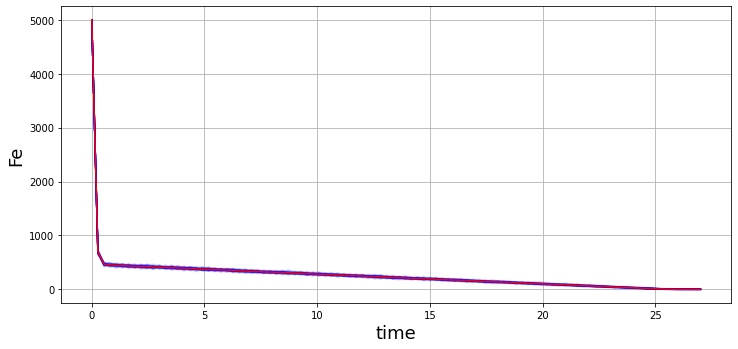

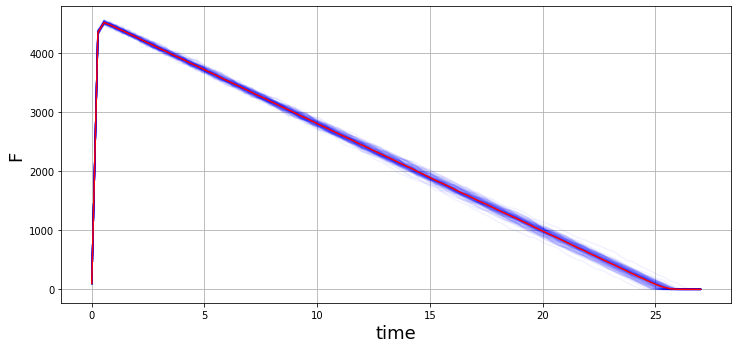

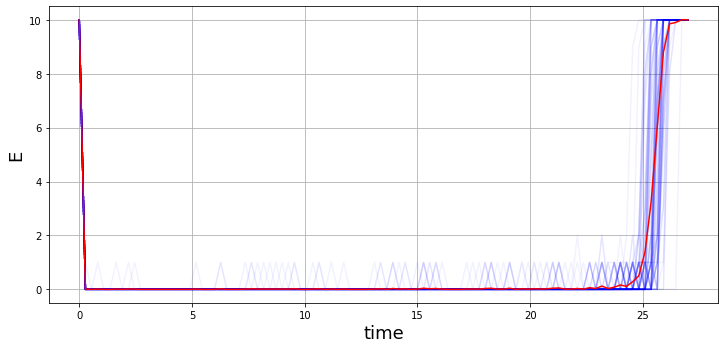

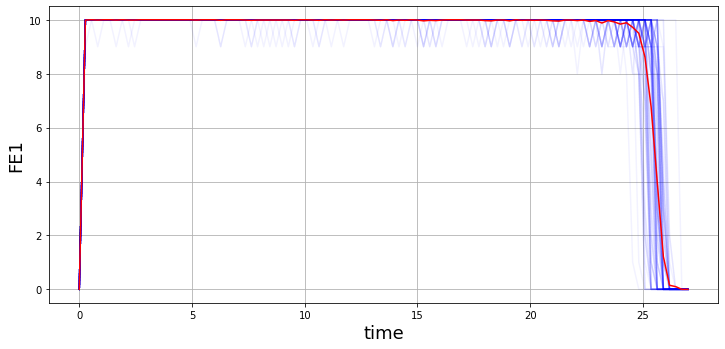

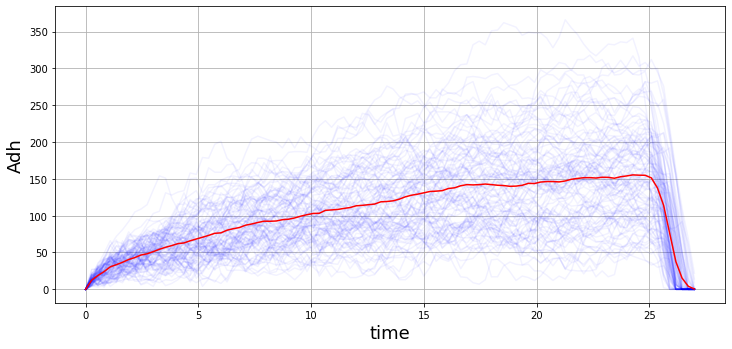

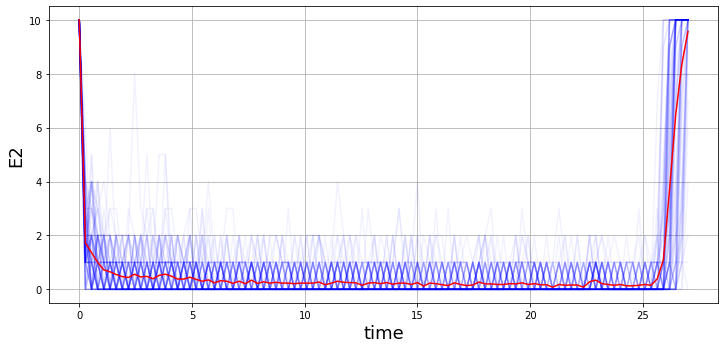

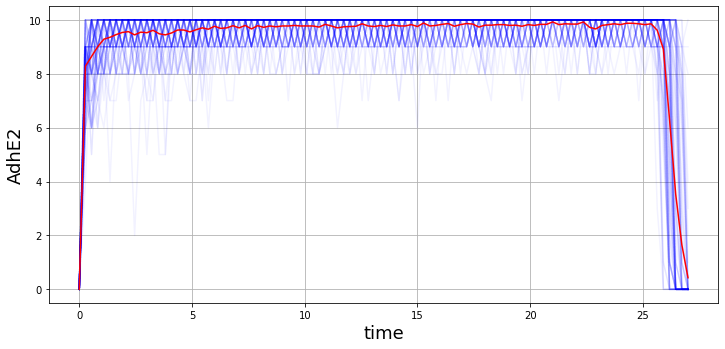

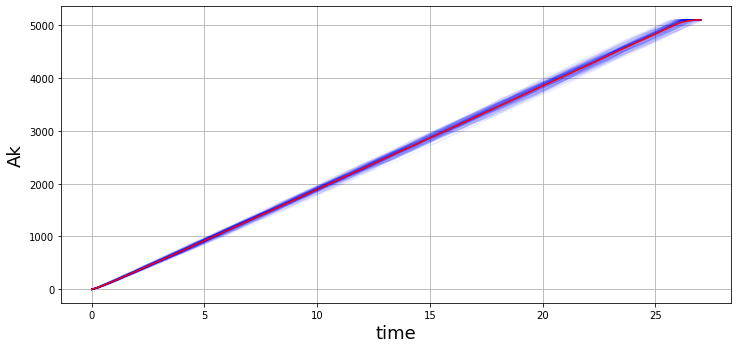

In [17]:
%pylab inline


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time",fontsize=18)
plt.ylabel("Fe",fontsize=18)
plt.grid()
for i in range(100):
    plt.plot(time_points,samples1[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 0].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("F",fontsize=18)
plt.grid()
for i in range(100):
    plt.plot(time_points,samples1[i,:,1],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 1].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("E",fontsize=18)
plt.grid()
for i in range(100):
    plt.plot(time_points,samples1[i,:,2],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 2].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("FE1",fontsize=18)
plt.grid()
for i in range(100-1):
    plt.plot(time_points,samples1[i,:,3],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 3].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("Adh",fontsize=18)
plt.grid()
for i in range(100-1):
    plt.plot(time_points,samples1[i,:,4],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 4].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("E2",fontsize=18)
plt.grid()
for i in range(100-1):
    plt.plot(time_points,samples1[i,:,5],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 5].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("AdhE2",fontsize=18)
plt.grid()
for i in range(100-1):
    plt.plot(time_points,samples1[i,:,6],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 6].mean(axis=0),color ="red")



plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=18)
plt.ylabel("Ak",fontsize=18)
plt.grid()
for i in range(100-1):
    plt.plot(time_points,samples1[i,:,7],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 7].mean(axis=0),color ="red")


In [ ]:
time_points = np.linspace(0,30,100)
samples2 = biocircuits.gillespie_ssa(propensityArray1, 
                                    update1, 
                                    population_0, 
                                    time_points, 
                                    size=100, 
                                    args=args2,
                                    progress_bar=True)

  0%|          | 0/100 [00:01<?, ?it/s]


ZeroDivisionError: ignored

In [ ]:
time_points2 = np.linspace(0, 25, 100)

samples2 = biocircuits.gillespie_ssa(propensityArray1, 
                                    update1, 
                                    population_0, 
                                    time_points2, 
                                    size=100, 
                                    args=args2,
                                    n_threads=10,
                                    progress_bar=True)

In [ ]:
samples2.shape

In [ ]:
%pylab inline


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("Fe")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 0].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("F")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,1],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 1].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("E")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,2],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 2].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("FE1")
plt.grid()
for i in range(100-1):
    plt.plot(time_points2,samples2[i,:,3],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 3].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("Adh")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,4],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 4].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("E2")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,5],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 5].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("AdhE2")
plt.grid()
for i in range(1000-1):
    plt.plot(time_points2,samples2[i,:,6],alpha=0.05, color ="blue")
plt.plot(time_points2,samples2[:, :, 6].mean(axis=0),color ="red")



plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("Ak")
plt.grid()
for i in range(100-1):
    plt.plot(time_points2,samples1[i,:,7],alpha=0.05, color ="blue")
plt.plot(time_points2,samples1[:, :, 7].mean(axis=0),color ="red")

Veamos ahora si agreamos un termino de reversibilidad a nuestras ecuaciones de produccion de ADH Y AK

\begin{equation}
    \begin{aligned}
    \frac{d[F]}{dt} & = -k_{1}[E_1][F] + k_{-1}[FE_1] + a_+ [F']- a_- [F],\\
    \frac{d[FE_1]}{dt} & = k_{1}[E_1][F] -(k_2 + k_{-1})[FE_1] + k_{-2}[Adh][E_1],\\
    \frac{d[E_1]}{dt} & = -k_{1}[E_1][F] -k_{-2}[Adh][E_1]+ (k_2 + k_{-1})[FE_1],\\
    \frac{d[Adh]}{dt} & = k_2 [FE_1] - k_{3}[E_2][Adh] + k_{-3}[AdhE_2]-k_{-2}[Adh][E_1].\\
    \frac{d[AdhE_2]}{dt} & = k_{3}[E_2][Adh]+k_{-4}[Ak][E_2] -(k_4 + k_{-3})[AdhE_2],\\
    \frac{d[E_2]}{dt} & = -k_{3}[E_2][Adh] -k_{-4}[Ak][E_2]+ (k_4 + k_{-3})[AdhE_2],\\
    \frac{d[Ak]}{dt} & = k_4 [AdhE_2]-k_{-4}[Ak][E_2].\\
    \end{aligned}
\end{equation}

Me basare en la simulacion realizada Michael Elowitz.

Tenemos entonces diversas propensidades, termino que denota la probabilidad de transicion de un estado a otro. Tenemos entonces:



| Reaction      | Propensity |
| ---------- | ---------- |
| $$F'-> F'+1, F -> F - 1$$| $$a_-*F$$|
| $$F'-> F'-1, F -> F+1$$| $$a_+*F'$$|
| $$F-> F-1,E_1 -> E_1-1, FE_1 -> FE_1+1$$| $$k_1(E_1)(F)$$|
|$Adh -> Adh-1,E_1 -> E_1-1,FE_1->FE_1+1$|$k_{-2}(Adh)(E_1)$|
| $$F-> F+1, E_1 -> E_1 +1, FE_1 -> FE_1 -1 $$| $$k_{-1}(FE_1)$$|
| $$FE_1 -> FE_1 - 1,E_1->E_1 +1, Adh -> Adh +1$$| $$k_2(FE_1)$$ |
| $$Adh -> Adh -> -1, E_2 ->E_2 -1, AdhE_2 +1$$| $$k_3(Adh)(E_2)$$|
| $$Adh -> Adh -> +1, E_2 ->E_2 +1, AdhE_2 -1$$|$$k_{-3}(AdhE_2)$$|
| $$AdhE_2 -> AdhE_2 -1, E_2 ->E_2 +1, Ak -> Ak+1$$| $$k_4(AdhE_2)$$|
|$Ak-> Ak-1,E_2->E_2-1, AdhE_2-> AdhE_2 +1$|$k_{-4}(Ak)(E_2)$|

Para empezar a codificar la simulacion, hacemos un arreglo que nos da los cambios para nuestras reaciones.

In [ ]:
"""
Ahora, definamos nuestras nuevas propensidades y updates.
"""

def propensityArrayRev(propensities,
                    population,
                    t,
                    k1, 
                    kn1,
                    k2,
                    kn2,
                    k3,
                    kn3,
                    k4,
                    kn4,
                    apos,
                    aneg
                   ):
    """
    Array de propensities que se actualiza ccon los parametros dados y con
    array de poblacion.
    """
    Fe, F, E1, FE1, Adh, E2, AdhE2,  Ak = population
    
    #Actualizar propensities.
    
    propensities[0] = aneg*F               # Fatty acid goes outside, Fatty inside goes down.
    propensities[1] = apos*Fe              # Fatty acid goes inside, Fatty inside goes up.
    propensities[2] = k1*F*E1              # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
    propensities[3] = kn2*Adh*E1           # Adh goes down, enzime 1 goes down, FE1 complex goes up.
    propensities[4] = kn1*(FE1)            # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
    propensities[5] = k2*(FE1)             # FE1 complex goes down, enzyme1 goes up, Adh group is created.
    propensities[6] = k3*Adh*E2            # Adh goes down, enzyme2 goes down, AdhE2 complex gous up.
    propensities[7] = kn3*(AdhE2)          # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
    propensities[8] = k4*(AdhE2)           # AdhE2 complex goes down, enzyme2 goes up, Ak is created.
    propensities[9] = kn4*Ak*E2            # Ak goes down, enzym2 goes down, AdhE2 complex goes up.



In [ ]:
"""
Columnas denotan
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
"""

updateRev = np.array(
    [
        [1,-1,0,0,0,0,0,0],                    # Fatty acid goes outside, Fatty inside goes down.
        [-1,1,0,0,0,0,0,0],                    # Fatty acid goes inside, Fatty inside goes up.
        [0,-1,-1,1,0,0,0,0],                   # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
        [0,0,-1,1,-1,0,0,0],                   # Adh goes down, enzime 1 goes down, FE1 complex goes up..
        [0,1,1,-1,0,0,0,0],                    # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
        [0,0,1,-1,1,0,0,0],                    # FE1 complex goes down, enzyme1 goes up, Adh group is created.
        [0,0,0,0,-1,-1,1,0],                    # Adh goes down, enzyme2 goes down, AdhE2 complex goes up.
        [0,0,0,0,1,1,-1,0],                     # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
        [0,0,0,0,0,1,-1,1],                    # AdhE2 complex goes down, enzyme2 goes up, Ak is created.     
        [0,0,0,0,0,-1,1,-1],                    # Ak goes down, enzym2 goes down, AdhE2 complex goes up.

    ],
    dtype = int
)

print(updateRev)



[[ 1 -1  0  0  0  0  0  0]
 [-1  1  0  0  0  0  0  0]
 [ 0 -1 -1  1  0  0  0  0]
 [ 0  0 -1  1 -1  0  0  0]
 [ 0  1  1 -1  0  0  0  0]
 [ 0  0  1 -1  1  0  0  0]
 [ 0  0  0  0 -1 -1  1  0]
 [ 0  0  0  0  1  1 -1  0]
 [ 0  0  0  0  0  1 -1  1]
 [ 0  0  0  0  0 -1  1 -1]]


In [ ]:

# k1 =10
# kn1 = 1
# k2 = 20
# kn2 = 5
# k3 =10
# kn3 = 1
# k4 = 20
# kn4 = 5
# apos =10
# aneg= 1



args3 = (10, 1, 20, 2,10, 1, 20, 2, 10, 1)
time_pointsRev = np.linspace(0, 30, 100)

#26 max time

"""
Population has the form
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
"""


population_Rev = np.array([5000, 100,10,0,0,10,0,0], dtype=int)
size = 10

samplesRev = np.empty((size, len(time_points), 8), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples1[i, :, :] = gillespieSim1(propensityArrayRev, updateRev, population_Rev, time_pointsRev, args=args3)

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


Populating the interactive namespace from numpy and matplotlib


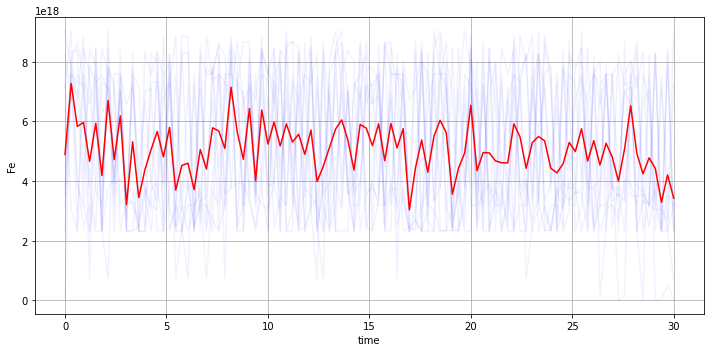

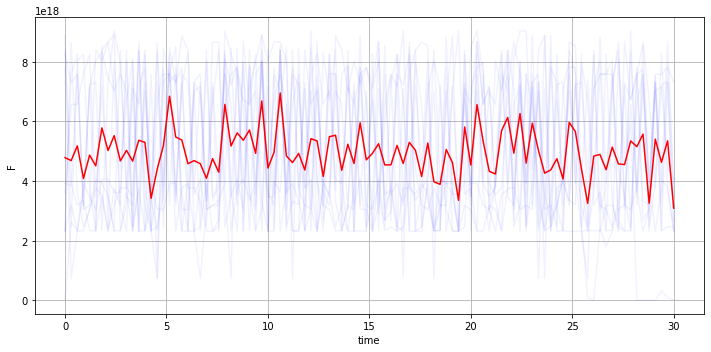

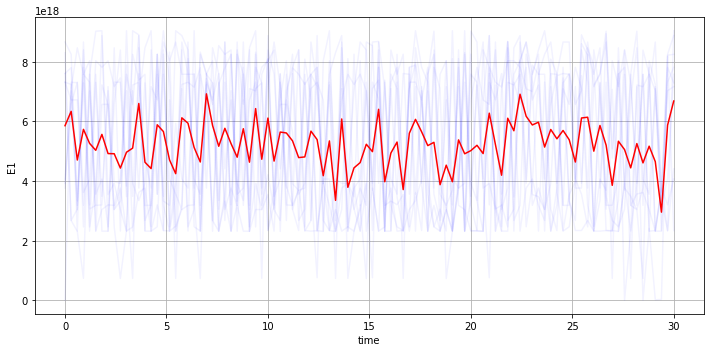

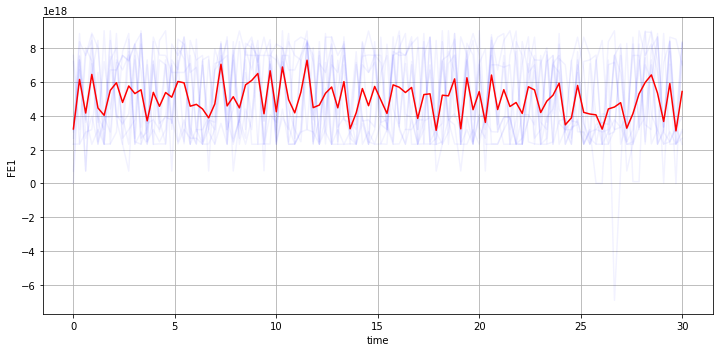

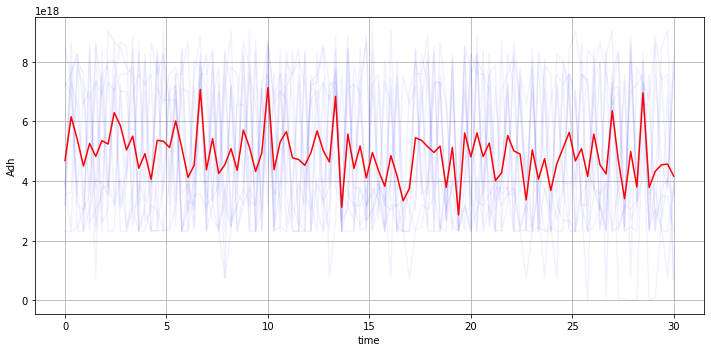

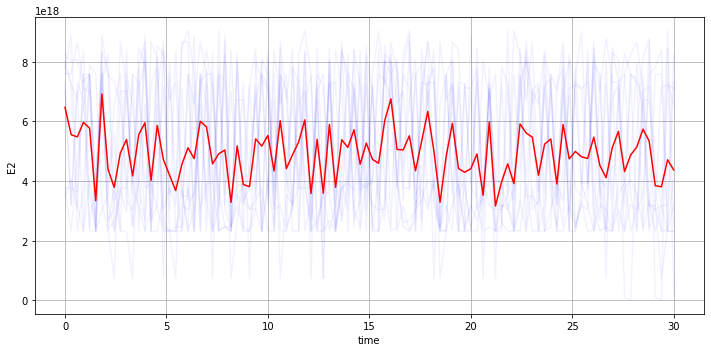

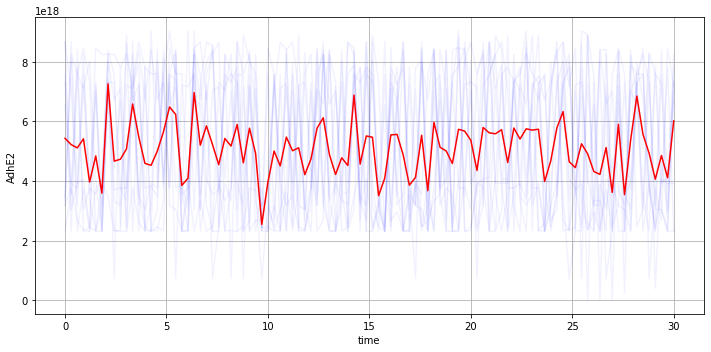

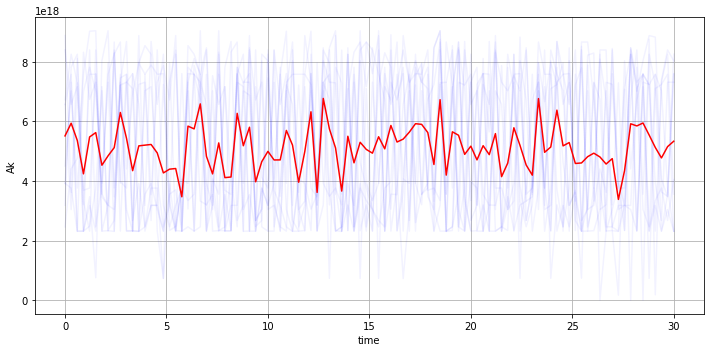

In [ ]:
%pylab inline


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("Fe")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 0].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("F")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,1],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 1].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("E1")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,2],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 2].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("FE1")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,3],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 3].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("Adh")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,4],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 4].mean(axis=0),color ="red")


plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("E2")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,5],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 5].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("AdhE2")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,6],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 6].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("Ak")
plt.grid()
for i in range(10):
    plt.plot(time_pointsRev,samplesRev[i,:,7],alpha=0.05, color ="blue")
plt.plot(time_pointsRev,samplesRev[:, :, 7].mean(axis=0),color ="red")






